# --------------- PROJECT EAGLE-EYE ----------------

# SAGEMAKER OBJECT DETECTION 
In this notebook we will be training a model with Amazon SageMaker OD.

## 1. SET UP

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)


sess = sagemaker.Session()

arn:aws:iam::743025358310:role/service-role/AmazonSageMaker-ExecutionRole-20210528T211254
CPU times: user 799 ms, sys: 108 ms, total: 907 ms
Wall time: 857 ms


In [2]:
bucket = "eagle-eye-dataset"
prefix = "OD_using_sagemaker/experiment3"

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, "object-detection", repo_version="latest")
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:1


In [4]:
import os
import urllib.request

In [7]:
%%bash
#creating directories to store the data and their annotation files
mkdir generated train train_annotation validation validation_annotation 

# 2. PREPARING DATA

We will be converting the annotation file from the COCO dataset into JSON annotation files. The Amazon SageMaker Object Detection algorithm expects lables to be indexed from 0. It also expects lables to be unique, successive and not skip any integers. For instance, if there are seven classes, the algorithm expects and the labels only be in the set [0,1,2,3,4,5,6].
Now we will convert to JSON annotation files.

We are having all the images in data folder and annotation file in annotations folder

In [8]:
#CREATING A DICTIONARY FOR GENERATING KEY,VALUE PAIR

import json
import logging


def get_coco_mapper():
    original_list = [
        1,2,3,4,5,6,7,8,9,
    ]
    iter_counter = 0
    COCO = {}
    for orig in original_list:
        COCO[orig] = iter_counter
        iter_counter += 1
    return COCO

In [9]:
# Let us use this dictionary, to create a look up method. Let us do so in a way that any dictionary could be used to create this method.


def get_mapper_fn(map):
    def mapper(in_category):
        return map[in_category]

    return mapper


fix_index_mapping = get_mapper_fn(get_coco_mapper())

In [10]:
# The method fix_index_mapping is essentially a look-up method, which we can use to convert lables

file_name = "./annotations/_annotations.coco.json"

with open(file_name) as f:
    js = json.load(f)
    images = js["images"]
    categories = js["categories"]
    annotations = js["annotations"]
    for i in images:
        jsonFile = i["file_name"]
        tmp_arr = jsonFile.split(".")
        jsonFile = "{}.{}.{}.json".format(tmp_arr[0],tmp_arr[1],tmp_arr[2])

        line = {}
        line["file"] = i["file_name"]
        line["image_size"] = [{"width": int(i["width"]), "height": int(i["height"]), "depth": 3}]
        line["annotations"] = []
        line["categories"] = []
        for j in annotations:
            if j["image_id"] == i["id"] and len(j["bbox"]) > 0:
                line["annotations"].append(
                    {
                        "class_id": int(fix_index_mapping(j["category_id"])),
                        "top": int(j["bbox"][1]),
                        "left": int(j["bbox"][0]),
                        "width": int(j["bbox"][2]),
                        "height": int(j["bbox"][3]),
                    }
                )
                class_name = ""
                for k in categories:
                    if int(j["category_id"]) == k["id"]:
                        class_name = str(k["name"])
                assert class_name is not ""
                line["categories"].append({"class_id": int(j["category_id"]), "name": class_name})
        if line["annotations"]:
            with open(os.path.join("generated", jsonFile), "w") as p:
                json.dump(line, p)

In [11]:
import os
import json

jsons = os.listdir("generated")

print("There are {} images have annotation files".format(len(jsons)))

There are 509 images have annotation files


In [12]:
# We will use 430 images for training the model and rest 43 for validation of model

import shutil

train_jsons = jsons[:430]
val_jsons = jsons[430:]

# Moving training files to the training folders => train,train_annotation
for i in train_jsons:
    tmp_arr = i.split(".")
    image_file = "./data/{}.{}.{}.jpg".format(tmp_arr[0],tmp_arr[1],tmp_arr[2])
    shutil.move(image_file, "./train/")
    shutil.move("./generated/" + i, "./train_annotation/")

# Moving validation files to the validation folders => validation,validation_annotation
for i in val_jsons:
    tmp_arr = i.split(".")
    image_file = "./data/{}.{}.{}.jpg".format(tmp_arr[0],tmp_arr[1],tmp_arr[2])
    shutil.move(image_file, "./validation/")
    shutil.move("./generated/" + i, "./validation_annotation/")

# 3. UPLOAD TO S3
Now we will be uploading our data to s3,so our model can use this

In [9]:
%%time

train_channel = prefix + "/train"
validation_channel = prefix + "/validation"
train_annotation_channel = prefix + "/train_annotation"
validation_annotation_channel = prefix + "/validation_annotation"

sess.upload_data(path="train", bucket=bucket, key_prefix=train_channel)
sess.upload_data(path="validation", bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path="train_annotation", bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(
    path="validation_annotation", bucket=bucket, key_prefix=validation_annotation_channel
)

s3_train_data = "s3://{}/{}".format(bucket, train_channel)
s3_validation_data = "s3://{}/{}".format(bucket, validation_channel)
s3_train_annotation = "s3://{}/{}".format(bucket, train_annotation_channel)
s3_validation_annotation = "s3://{}/{}".format(bucket, validation_annotation_channel)

CPU times: user 6.89 s, sys: 449 ms, total: 7.34 s
Wall time: 51 s


# 4. SETTING OUTPUT LOCATION
Here we will setup an output location at S3, where the model artifact will be dumped.

In [5]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)

We are done with data preparation part.Now we will move towards model training.

# 5. LAUNCHING THE TRAINING JOB
We are creating a sageMaker.estimator.Estimator object. This estimator will launch the training job.

In [10]:
eagle_eye_sagemaker_model = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    volume_size=50,
    max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

# 6. SETTING UP HYPERPARAMETERS
Hyperparameters help in configuring the training job

In [11]:
eagle_eye_sagemaker_model.set_hyperparameters(
    base_network="resnet-50",
    use_pretrained_model=1,
    num_classes=5,
    mini_batch_size=16,
    epochs=100,
    learning_rate=0.001,
    lr_scheduler_step="10",
    lr_scheduler_factor=0.1,
    optimizer="adam",
    overlap_threshold=0.5,
    nms_threshold=0.45,
    image_shape=240,
    label_width=350,
    num_training_samples=290,
)

# 7. CREATING DATA CHANNEL

In [12]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="image/jpeg",
    s3_data_type="S3Prefix",
)

validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="image/jpeg",
    s3_data_type="S3Prefix",
)

train_annotation = sagemaker.inputs.TrainingInput(
    s3_train_annotation,
    distribution="FullyReplicated",
    content_type="image/jpeg",
    s3_data_type="S3Prefix",
)

validation_annotation = sagemaker.inputs.TrainingInput(
    s3_validation_annotation,
    distribution="FullyReplicated",
    content_type="image/jpeg",
    s3_data_type="S3Prefix",
)

data_channels = {
    "train": train_data,
    "validation": validation_data,
    "train_annotation": train_annotation,
    "validation_annotation": validation_annotation,
}

# 8. TRAINING THE MODEL

In [13]:
eagle_eye_sagemaker_model.fit(inputs=data_channels, logs=True)

2021-06-25 12:48:45 Starting - Starting the training job...
2021-06-25 12:49:09 Starting - Launching requested ML instancesProfilerReport-1624625325: InProgress
......
2021-06-25 12:50:09 Starting - Preparing the instances for training.........
2021-06-25 12:51:37 Downloading - Downloading input data
2021-06-25 12:51:37 Training - Downloading the training image......
2021-06-25 12:52:44 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[06/25/2021 12:52:47 INFO 140347972593472] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold': '0.45', 'num_training_samples': '', 'i

# 9. PLOTTING THE GRAPH

In [14]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

client = boto3.client("logs")
BASE_LOG_NAME = "/aws/sagemaker/TrainingJobs"


def plot_object_detection_log(model, title):
    logs = client.describe_log_streams(
        logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name
    )
    cw_log = client.get_log_events(
        logGroupName=BASE_LOG_NAME, logStreamName=logs["logStreams"][0]["logStreamName"]
    )

    mAP_accs = []
    for e in cw_log["events"]:
        msg = e["message"]
        if "validation mAP <score>=" in msg:
            num_start = msg.find("(")
            num_end = msg.find(")")
            mAP = msg[num_start + 1 : num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print("Maximum mAP: %f " % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel("Epochs")
    plt.ylabel("Mean Avg Precision (mAP)")
    (val_plot,) = ax.plot(range(len(mAP_accs)), mAP_accs, label="mAP")
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))
    plt.show()


mAP tracking for job: object-detection-2021-06-25-12-48-45-545
Maximum mAP: 0.992739 


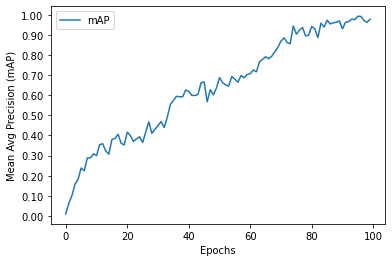

In [15]:
plot_object_detection_log(eagle_eye_sagemaker_model, "mAP tracking for job: " + eagle_eye_sagemaker_model._current_job_name)

# 8. DEPLOYMENT

In [16]:
object_detector = eagle_eye_sagemaker_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-----------------!

In [17]:
#endpoint_name = 'object-detection-2021-06-09-16-18-54-007'
print(object_detector)

## Deployment Using a model artifacts

In [20]:
trainedmodel = sagemaker.model.Model(
    model_data='s3://eagle-eye-dataset/OD_using_sagemaker/experiment1/output/object-detection-2021-06-22-09-47-42-275/output/model.tar.gz',
    image_uri=training_image,  #
    role=role) 

trainedmodel.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')


-----------------!